In [ ]:
!pip install adjustText
!pip install biopython
!pip install dmslogo

from google.colab import output
output.clear()

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gzip
from functools import partial
import ast
import dmslogo

import arviz as az
import seaborn as sns
import scipy.cluster.hierarchy as hierarchy
import scipy.sparse as sparse
import scipy.stats as stats
from scipy import spatial

import Bio
from Bio import motifs
from operator import itemgetter
import networkx as nx
from networkx.algorithms import bipartite

from sklearn.datasets import make_biclusters
from sklearn.cluster import SpectralCoclustering
from sklearn.metrics import consensus_score

from adjustText import adjust_text
import matplotlib.patheffects as PathEffects

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import (random_split, DataLoader, TensorDataset, ConcatDataset)

# from tqdm.auto import tqdm
# tqdm.pandas()
from tqdm.notebook import tqdm

pd.set_option('display.max_columns', None)

if torch.cuda.is_available():
    use_cuda = True
    torch.backends.cudnn.benchmark = True
    print(f'GPU available: {torch.cuda.get_device_name(0)} ({torch.cuda.device_count()} count)')
else:
    print('No GPU available')

No GPU available


In [ ]:
class constants():
    def __init__(self):
        self.STANDARD_NT = ['A','C','G','T']
        self.DNA_COMPLEMENTS = {'A':'T', 'G':'C', 'T':'A', 'C':'G'}
constants = constants()

class utils():   
    @staticmethod
    def pad_pssm(row, pad_len=24, column_name='pssm'):
        padded_pssm = np.zeros((4, pad_len))
        padded_pssm[:, 0:row['length']] = row[column_name]
        return padded_pssm

    @staticmethod
    def pad_seq_tensor(seq_tensor, pad_len=217, dim=-1):
        assert seq_tensor.shape[dim] <= pad_len
        padded_tensor = torch.zeros((4, pad_len))
        padded_tensor[:, 0:seq_tensor.shape[dim]] = seq_tensor
        return padded_tensor
        
    @staticmethod
    def dna2tensor(sequence_str, vocab_list=constants.STANDARD_NT):
        seq_tensor = np.zeros((len(vocab_list), len(sequence_str)))
        for letterIdx, letter in enumerate(sequence_str):
            seq_tensor[vocab_list.index(letter), letterIdx] = 1
        seq_tensor = torch.Tensor(seq_tensor)
        return seq_tensor

    @staticmethod
    def row_dna2tensor(row, in_column_name='padded_seq' , vocab=['A', 'C', 'G', 'T']):
        sequence_str = row[in_column_name]
        seq_idxs = torch.tensor([vocab.index(letter) for letter in sequence_str])
        sequence_tensor = F.one_hot(seq_idxs, num_classes=4).transpose(1,0)
        return sequence_tensor.type(torch.float32)
    
    @staticmethod
    def append_zero_tensor(row, in_column_name='seq_tensor', target_len=217):
        seq__tensor = row[in_column_name]
        num_zeros = target_len - seq__tensor.shape[-1]
        zeros = torch.zeros((4, num_zeros))
        padded_seq = torch.cat( (seq__tensor, zeros), dim=-1 )
        return padded_seq
    
    @staticmethod
    def reverse_complement_onehot(x, nt_order=constants.STANDARD_NT, 
                              complements=constants.DNA_COMPLEMENTS):
        comp_alphabet = [ complements[nt] for nt in nt_order ]
        permutation = [ nt_order.index(nt) for nt in comp_alphabet ]   
        return torch.flip(x[..., permutation, :], dims=[-1])

    @staticmethod
    def append_zero_tensor(row, in_column_name='seq_tensor', target_len=217):
        seq__tensor = row[in_column_name]
        num_zeros = target_len - seq__tensor.shape[-1]
        zeros = torch.zeros((4, num_zeros))
        padded_seq = torch.cat( (seq__tensor, zeros), dim=-1 )
        return padded_seq

def counts_to_ppm(in_tensor):
    motif = in_tensor.div( in_tensor.sum(0) )
    return motif

def ppm_to_pwm(in_tensor,bkg=[0.25,0.25,0.25,0.25]):
    motif = in_tensor.div(torch.tensor(bkg).unsqueeze(1)).log2()
    return motif

def ppm_to_U(in_tensor):
    return (in_tensor.log2() * in_tensor).sum(0).mul(-1.)

def ppm_to_IC(in_tensor):
    return in_tensor * ppm_to_U( in_tensor ).mul(-1.).add(2.)

def single_scatterplot(data_df, x_axis, y_axis, color_axis, fig_size=(15,8), dot_size=0.5, title='',
                       dot_alpha=0.5, style='seaborn-whitegrid', colormap='winter',
                       x_label='Experimental', y_label='Predicted', color_label='l2fc SE', title_font_size=18,
                       title_font_weight='medium', axis_font_size=16):
    with plt.style.context(style):
        fig, ax = plt.subplots()    
        data_df.plot(kind='scatter', x=x_axis, y=y_axis, figsize=fig_size, c=color_axis, ax=ax,
                        alpha=dot_alpha, s=dot_size, colormap=colormap)
        plt.xlabel(x_label, fontsize=axis_font_size)
        plt.ylabel(y_label, fontsize=axis_font_size)

        f = plt.gcf()
        cax = f.get_axes()[1]
        cax.set_ylabel(color_label, fontsize=axis_font_size)

        x_min, y_min = data_df[[x_axis, y_axis]].min().to_numpy() 
        x_max, y_max = data_df[[x_axis, y_axis]].max().to_numpy()
        min_point, max_point = min(x_min, y_min), max(x_max, y_max)
        plt.plot((min_point,max_point), (min_point,max_point), color='black', linestyle='--', alpha=0.5)

        Pearson = round(data_df[[x_axis, y_axis]].corr(method='pearson')[x_axis][1], 2)
        Spearman = round(data_df[[x_axis, y_axis]].corr(method='spearman')[x_axis][1], 2)

        #title = f'{title}  |  Pearson={Pearson}  Spearman={Spearman}'
        title = f'{title}  |  Pearson {Pearson}'
        ax.set_title(title, fontdict={'fontsize': title_font_size, 'fontweight': title_font_weight}, pad=15)
        
        ax.tick_params(axis='both', which='major', labelsize=axis_font_size)

def string_to_numpy(text, dtype=None):
    """
    Convert text into 1D or 2D arrays using np.matrix().
    The result is returned as an np.ndarray.
    """
    import re
    text = text.strip()
    # Using a regexp, decide whether the array is flat or not.
    # The following matches either: "[1 2 3]" or "1 2 3"
    is_flat = bool(re.match(r"^(\[[^\[].+[^\]]\]|[^\[].+[^\]])$",
                            text, flags=re.S))
    # Replace newline characters with semicolons.
    text = text.replace("]\n", "];")
    # Prepare the result.
    result = np.asarray(np.matrix(text, dtype=dtype))
    return result.flatten() if is_flat else result

def str2tensor(array_string):
    return torch.tensor([float(item) for item in array_string.lstrip('[[ ').rstrip(' ]]').split(' ') if item != ''])

def ppm_to_IC_alt(in_tensor):
    U = (in_tensor.log2() * in_tensor).sum(dim=1).mul(-1.)
    return in_tensor * U[:, None, :].mul(-1.).add(2.)

def tensor_to_pandas(in_tensor, tokens=constants.STANDARD_NT, colors=['green','orange','red','blue']):
    data = []
    my_array = in_tensor.cpu().numpy()
    for nt, score_vec,color in zip(tokens,[ sub_a for sub_a in my_array ],colors):
         _ = [ data.append([j,nt,score,color]) for j,score in enumerate(score_vec) ]
    return pd.DataFrame(data=data,columns=['site', 'letter', 'height','color'])

def matrix_to_dms(in_tensor, ax=None, y_max=2, fontaspect=.55, widthscale=0.8,
                  axisfontscale=0.6, heightscale=0.8, colors=['green','blue','orange','red']):
    motif = tensor_to_pandas(in_tensor, colors=colors)
    fig, ax = dmslogo.draw_logo(data=motif,
                                x_col='site',
                                letter_col='letter',
                                letter_height_col='height',
                                color_col='color',
                                ax=ax,
                                fixed_ymax=y_max,
                                fontaspect=fontaspect,
                                widthscale=widthscale,
                                axisfontscale=axisfontscale,
                                heightscale=heightscale)
    return fig, ax

### Motif contributions

In [ ]:
# programs = pd.read_table('/content/drive/MyDrive/data/BODA2_MPRA/STREME_topic_modeling/BODA_topics.txt',
#                          sep='\t', header=0, index_col=0)
# programs = programs / programs.max(axis=0)

# boda2_tf_df = pd.read_csv('/content/drive/MyDrive/data/tf_motifs/HOCOMOCO_truly_full_BODA2_contributions.txt', sep=" ", low_memory=False)

# short_names = [x.split('_')[0] for x in boda2_tf_df['name'].tolist()]

# short_names_with_distinction = short_names[:2]
# for i in range(2, len(short_names)):
#     if short_names[i] == short_names[i-1]:
#         if short_names[i] == short_names[i-2]:
#             short_names_with_distinction.append(f'{short_names[i]}.2')
#         else:
#             short_names_with_distinction.append(f'{short_names[i]}.1')
#     else:
#         short_names_with_distinction.append(short_names[i])

# KLs = boda2_tf_df[['KLdiv_K562', 'KLdiv_HepG2', 'KLdiv_SKNSH']].min(axis=1)
# text_alphas = (1 - KLs / KLs.max())**3

In [ ]:
# boda2_tf_df = pd.read_csv('/content/drive/MyDrive/data/BODA2_MPRA/STREME_library_analysis/streme_TFs_contributions.txt', sep=" ", low_memory=False)
# boda2_tf_df.at[0, 'contribution_HepG2'] = boda2_tf_df.iloc[0]['contribution_HepG2'] / 2

# # duplicated_set = boda2_tf_df[boda2_tf_df['Target_ID_short'].duplicated()]['Target_ID_short'].tolist()
# # short_names_with_distinction = []
# # for i in range(len(boda2_tf_df)):
# #     short_name = boda2_tf_df.iloc[i]['Target_ID_short']
# #     if short_name in duplicated_set:
# #         short_names_with_distinction.append(f'{short_name} (S-{i})')
# #     else:
# #         short_names_with_distinction.append(short_name)

# short_names_with_distinction = [f'{short_name} (S-{i+1})' for i, short_name in enumerate(boda2_tf_df['Target_ID_short'].tolist())]

# boda2_tf_df['Target_ID_short'] = short_names_with_distinction

# merged_tf_df = boda2_tf_df.merge(programs, on='motif_id').reset_index(drop=True)

In [ ]:
boda2_streme_tfs = pd.read_csv('/content/drive/MyDrive/data/BODA2_MPRA/STREME_library_analysis/streme_TFs_ultimate_merge.txt', sep=" ", low_memory=False)
boda2_streme_tfs.loc[0, 'contribution_HepG2'] = 0.5 * boda2_streme_tfs.loc[0, 'contribution_HepG2']

In [ ]:
# index2color = { i: c for i, c in zip(
#     range(13),
#     ['#993404', '#fddaec', '#fed9a6', '#D500FF', '#ccebc5', '#253494', '#ffffcc', '#e5d8bd', '#FF0004', '#41b6c4', '#decbe4', '#d95f0e', '#fe9929']
# ) }

# program_columns = [str(i) for i in range(13)]
# colors = [index2color[int(idx)] for idx in merged_tf_df[program_columns].idxmax(axis=1).tolist()]

import matplotlib as mpl
from matplotlib.colors import to_rgba

hepg2_1 = '#993404'
hepg2_2 = '#d95f0e'
hepg2_3 = '#fe9929'

k562_1 = '#253494'
k562_2 = '#41b6c4'

sknsh_1 = '#D500FF' # '#FF00D0' # 
sknsh_2 = '#FF0004'
sknsh_3 = '#FF5CB0' # #fddaec

extra_1 = '#fed9a6'
extra_2 = '#ccebc5'
extra_3 = '#ffffcc'
extra_4 = '#e5d8bd'
extra_5 = '#decbe4'

blank   = '#f2f2f2'

color_order =  [hepg2_1,sknsh_3,extra_1,sknsh_1,extra_2,k562_1,extra_3,extra_4,sknsh_2,k562_2,extra_5,hepg2_2,hepg2_3]
colors =  [ mpl.colors.to_rgba(x) for x in color_order]


BG_WHITE = "#fbf9f4"
GREY_LIGHT = "#b4aea9"
GREY50 = "#7F7F7F"
GREY30 = "#4d4d4d"
BLUE_DARK = "#1B2838"
BLUE = "#2a475e"

In [ ]:
short_names_with_distinction = boda2_streme_tfs['ultimate_id'].tolist()
programs = boda2_streme_tfs[[str(i) for i in range(13)]]
tf_program_colors = [colors[i] for i in programs.idxmax(axis=1).astype(int).tolist()]

# top_motif_idxs = [int(tup[0])-1 for tup in programs.idxmax().str.split('-').tolist()]
# motifs_to_display = [short_names_with_distinction[i] for i in top_motif_idxs]

motifs_to_display = [short_names_with_distinction[i] for i in programs.idxmax().tolist()]
colors_to_display = [tf_program_colors[i] for i in programs.idxmax().tolist()]

remove_idxs = programs.idxmax().tolist()
second_idxmaxs = programs[~programs.index.isin(remove_idxs)].idxmax().tolist()

motifs_to_display += [short_names_with_distinction[i] for i in second_idxmaxs]
colors_to_display += [tf_program_colors[i] for i in second_idxmaxs]

display_dict = dict(zip(motifs_to_display, colors_to_display))

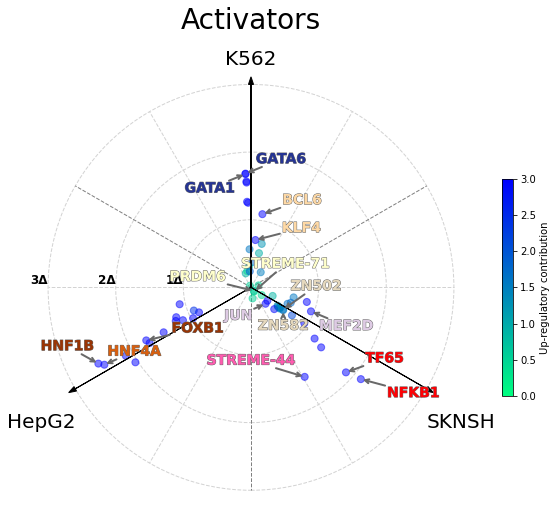

In [ ]:
cell_types = ['K562', 'HepG2', 'SKNSH']

pos_filter = (boda2_streme_tfs[['contribution_K562', 'contribution_HepG2', 'contribution_SKNSH']].mean(axis=1) >= 0)
short_names_in_group = boda2_streme_tfs[pos_filter]['ultimate_id'].tolist()

group_motifs_to_display = set(short_names_in_group) & set(motifs_to_display)
group_motifs_to_display = list(group_motifs_to_display)
group_motifs_to_display.remove('HNF4A (S-56)')
# group_motifs_to_display.remove('STREME-44')
# group_motifs_to_display += ['MEF2D (S-15)', 'SOX9 (S-51)', 'KLF4 (S-39)', 'ZN502 (S-75)', 'TWST1 (S-78)', 'TF65 (S-96)', 'GATA6 (S-17)']

point_array = boda2_streme_tfs[pos_filter][['contribution_K562', 'contribution_HepG2', 'contribution_SKNSH']].to_numpy()

title='Activators'
axis_labels=cell_types
R=3
figsize=(10,8)
min_color=0
max_color=3
cmap=mpl.cm.get_cmap('winter_r') #mpl.cm.Blues
axis_color='black'
soft_guideline_color='lightgrey'
mid_guideline_color='grey'
soft_guideline_stlye='--'
mid_guideline_stlye='--'
soft_guideline_width=1
mid_guideline_width=1
label_padding = 0.5
axis_arrow_head_scale=0.025
axis_label_fontsize=20
title_fontsize=28
title_y = 1.08
colorbar_label='Up-regulatory contribution'
colorbar_aspect=20
colorbar_shrink=0.5
dot_alpha=0.5
rasterized=True
dot_size=200
color_list=None
colorbar=True
inner_radii = None#[0.75, 2]
dot_edgecolor = 'gray'
    
x1, y1 = R*np.cos(np.deg2rad(30)), R*np.sin(np.deg2rad(30))
floor_R =  np.floor(R)
floor_x1, floor_y1 = floor_R*np.cos(np.deg2rad(30)), floor_R*np.sin(np.deg2rad(30))

fig, ax = plt.subplots(figsize=figsize)
plt.axis('equal')

#--- Get coloring for minimum
if color_list is None:
    #min_color, max_color = point_array.min(axis=1).min(), point_array.min(axis=1).max()
    color_values = point_array.max(axis=1) #point_array.min(axis=1)
    norm = mpl.colors.Normalize(vmin=min_color, vmax=max_color)
    color_list = cmap(color_values)

#--- Remove frame
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

#---Remove ticks
plt.xticks([])
plt.yticks([])

#--- Line guides
ax.plot( [0, 0], [0, -floor_R], color=mid_guideline_color, linestyle=mid_guideline_stlye, linewidth=mid_guideline_width, zorder=1)
ax.plot([0, floor_x1], [0, floor_y1], color=mid_guideline_color, linestyle=mid_guideline_stlye, linewidth=mid_guideline_width, zorder=1)
ax.plot([0, -floor_x1], [0,  floor_y1], color=mid_guideline_color, linestyle=mid_guideline_stlye, linewidth=mid_guideline_width, zorder=1)

ax.plot([0, floor_R], [0, 0], color=soft_guideline_color, linestyle=soft_guideline_stlye, linewidth=soft_guideline_width, zorder=1)
ax.plot([0, -floor_R], [0, 0], color=soft_guideline_color, linestyle=soft_guideline_stlye, linewidth=soft_guideline_width, zorder=1)

ax.plot([0, -floor_y1], [0, floor_x1], color=soft_guideline_color, linestyle=soft_guideline_stlye, linewidth=soft_guideline_width, zorder=1)
ax.plot([0, floor_y1], [0, floor_x1], color=soft_guideline_color, linestyle=soft_guideline_stlye, linewidth=soft_guideline_width, zorder=1)

ax.plot([0, -floor_y1], [0, -floor_x1], color=soft_guideline_color, linestyle=soft_guideline_stlye, linewidth=soft_guideline_width, zorder=1)
ax.plot([0, floor_y1], [0, -floor_x1], color=soft_guideline_color, linestyle=soft_guideline_stlye, linewidth=soft_guideline_width, zorder=1)

#--- Circles

if not inner_radii:
    inner_radii = np.arange(1, floor_R+1)   
for radius in inner_radii:
    ax.add_patch(plt.Circle((0,0), radius, color=soft_guideline_color, fill=False,
                            linestyle=soft_guideline_stlye, linewidth=soft_guideline_width, zorder=1))

#--- Main axes
ax.arrow(0, 0, 0, R, color=axis_color, shape='full', head_width=axis_arrow_head_scale * R, zorder=2)
ax.arrow(0, 0, x1, -y1, color=axis_color, shape='full', head_width=axis_arrow_head_scale * R, zorder=2)
ax.arrow(0, 0, -x1, -y1, color=axis_color, shape='full', head_width=axis_arrow_head_scale * R, zorder=2)

if axis_labels:
    ax.text(0, R + 0.75*label_padding, axis_labels[0], ha='center', va='center', fontsize=axis_label_fontsize)
    ax.text(-x1 - label_padding, -y1 - label_padding, axis_labels[1], ha='center', va='center', fontsize=axis_label_fontsize)
    ax.text(x1 + label_padding, -y1 - label_padding, axis_labels[2], ha='center', va='center', fontsize=axis_label_fontsize)

#--- Radii labels
for radius in inner_radii:
    ax.text(-radius, 0, f'{int(radius)}\u0394', ha='right', va='bottom', fontsize=12, fontweight='demibold')

#--- Plot points
shifted_points = point_array - point_array.min(axis=1)[:, None]

Xs = []
Ys = []
for row in range(shifted_points.shape[0]):
    point = shifted_points[row, :]
    min_dim = point.argmin()
    max_dim = point.argmax()

    mid_dim = [0, 1, 2]
    mid_dim.remove(min_dim)
    mid_dim.remove(max_dim)
    mid_dim = mid_dim[0]

    temp_r = point[max_dim]
    temp_theta_shift = 60 * point[mid_dim] / point[max_dim]
    if max_dim == 0:
        if mid_dim == 1:
            temp_theta = 90 + temp_theta_shift
        elif mid_dim == 2:
            temp_theta = 90 - temp_theta_shift
    elif max_dim == 1:
        if mid_dim == 0:
            temp_theta = 210 - temp_theta_shift
        elif mid_dim == 2:
            temp_theta = 210 + temp_theta_shift
    elif max_dim == 2:
        if mid_dim == 1:
            temp_theta = 330 - temp_theta_shift
        elif mid_dim == 0:
            temp_theta = -30 + temp_theta_shift

    temp_x = temp_r * np.cos(np.deg2rad(temp_theta))
    temp_y = temp_r * np.sin(np.deg2rad(temp_theta))        
    Xs.append(temp_x)
    Ys.append(temp_y)

ax.scatter(Xs, Ys, color=color_list, alpha=dot_alpha, marker='.', rasterized=rasterized, zorder=2, s=dot_size)  
if title:
    plt.title(title, fontsize=title_fontsize, y=title_y)

#--- Plot colorbar
if colorbar:
    cax, cbar_kwds = mpl.colorbar.make_axes(ax, location = 'right',
                              fraction=0.15, shrink=colorbar_shrink, aspect=colorbar_aspect)
    cb = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, orientation='vertical')
    if colorbar_label:
        cb.set_label(colorbar_label)

TEXTS = []
for text in group_motifs_to_display:
    i = short_names_in_group.index(text)
    x = Xs[i]
    y = Ys[i]
    c = display_dict[text]
    txt_to_append = ax.text(x, y, text.split(' ')[0], color=c, fontsize=14, fontweight='bold')
    txt_to_append.set_path_effects([PathEffects.withStroke(linewidth=1, foreground='dimgray')])
    TEXTS.append(txt_to_append)

adjust_text(
    TEXTS, 
    expand_points=(2, 2),
    arrowprops=dict(
        arrowstyle="->", 
        color='dimgray', #GREY50, 
        lw=2,
        alpha=1
    ),
    ax=fig.axes[0]
)

plt.show()

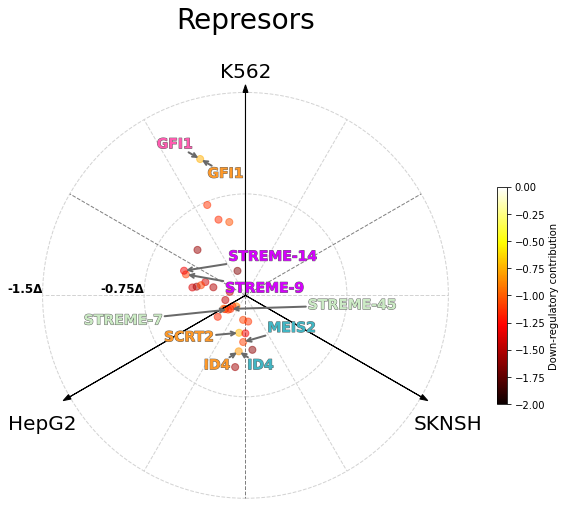

In [ ]:
non_nan_filter = boda2_streme_tfs['contribution_K562'].notnull()
neg_filter = (boda2_streme_tfs[['contribution_K562', 'contribution_HepG2', 'contribution_SKNSH']].mean(axis=1) < 0) & non_nan_filter

short_names_in_group = boda2_streme_tfs[neg_filter]['ultimate_id'].tolist()
group_motifs_to_display = set(short_names_in_group) & set(motifs_to_display)
group_motifs_to_display = list(group_motifs_to_display)
# group_motifs_to_display.remove('STREME-7')
# group_motifs_to_display.remove('STREME-14')
# group_motifs_to_display += ['GFI1 (S-2)', 'HES7 (S-13)', 'E2F5 (S-25)', 'RFX2 (S-95)', 'ID4 (S-5)',
#                             'STREME-9', 'STREME-27', 'STREME-42']

point_array = boda2_streme_tfs.loc[neg_filter][['contribution_K562', 'contribution_HepG2', 'contribution_SKNSH']].to_numpy()
point_array = -point_array

title='Represors'
axis_labels=cell_types
R=1.5
figsize=(10,8)
min_color=0
max_color=2
cmap=mpl.cm.get_cmap('hot') #mpl.cm.Reds
axis_color='black'
soft_guideline_color='lightgrey'
mid_guideline_color='grey'
soft_guideline_stlye='--'
mid_guideline_stlye='--'
soft_guideline_width=1
mid_guideline_width=1
label_padding = 0.2
axis_arrow_head_scale=0.025
axis_label_fontsize=20
title_fontsize=28
title_y = 1.1
colorbar_label='Down-regulatory contribution'
colorbar_aspect=20
colorbar_shrink=0.5
dot_alpha=0.5
rasterized=True
dot_size=200
color_list=None
colorbar=True
inner_radii = [0.75, 1.5]
dot_edgecolor = 'gray'
    
x1, y1 = R*np.cos(np.deg2rad(30)), R*np.sin(np.deg2rad(30))
if inner_radii is not None:
    floor_R = inner_radii[-1]
else:
    floor_R = np.floor(R)
floor_x1, floor_y1 = floor_R*np.cos(np.deg2rad(30)), floor_R*np.sin(np.deg2rad(30))

fig, ax = plt.subplots(figsize=figsize)
plt.axis('equal')

#--- Get coloring for minimum
if color_list is None:
    #min_color, max_color = point_array.min(axis=1).min(), point_array.min(axis=1).max()
    color_values = point_array.max(axis=1) #point_array.min(axis=1)
    norm = mpl.colors.Normalize(vmin=-max_color, vmax=min_color)
    color_list = cmap(color_values)

#--- Remove frame
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

#---Remove ticks
plt.xticks([])
plt.yticks([])

#--- Line guides
ax.plot( [0, 0], [0, -floor_R], color=mid_guideline_color, linestyle=mid_guideline_stlye, linewidth=mid_guideline_width, zorder=1)
ax.plot([0, floor_x1], [0, floor_y1], color=mid_guideline_color, linestyle=mid_guideline_stlye, linewidth=mid_guideline_width, zorder=1)
ax.plot([0, -floor_x1], [0,  floor_y1], color=mid_guideline_color, linestyle=mid_guideline_stlye, linewidth=mid_guideline_width, zorder=1)

ax.plot([0, floor_R], [0, 0], color=soft_guideline_color, linestyle=soft_guideline_stlye, linewidth=soft_guideline_width, zorder=1)
ax.plot([0, -floor_R], [0, 0], color=soft_guideline_color, linestyle=soft_guideline_stlye, linewidth=soft_guideline_width, zorder=1)

ax.plot([0, -floor_y1], [0, floor_x1], color=soft_guideline_color, linestyle=soft_guideline_stlye, linewidth=soft_guideline_width, zorder=1)
ax.plot([0, floor_y1], [0, floor_x1], color=soft_guideline_color, linestyle=soft_guideline_stlye, linewidth=soft_guideline_width, zorder=1)

ax.plot([0, -floor_y1], [0, -floor_x1], color=soft_guideline_color, linestyle=soft_guideline_stlye, linewidth=soft_guideline_width, zorder=1)
ax.plot([0, floor_y1], [0, -floor_x1], color=soft_guideline_color, linestyle=soft_guideline_stlye, linewidth=soft_guideline_width, zorder=1)

#--- Circles

if not inner_radii:
    inner_radii = np.arange(1, floor_R+1)   
for radius in inner_radii:
    ax.add_patch(plt.Circle((0,0), radius, color=soft_guideline_color, fill=False,
                            linestyle=soft_guideline_stlye, linewidth=soft_guideline_width, zorder=1))

#--- Main axes
ax.arrow(0, 0, 0, R, color=axis_color, shape='full', head_width=axis_arrow_head_scale * R, zorder=2)
ax.arrow(0, 0, x1, -y1, color=axis_color, shape='full', head_width=axis_arrow_head_scale * R, zorder=2)
ax.arrow(0, 0, -x1, -y1, color=axis_color, shape='full', head_width=axis_arrow_head_scale * R, zorder=2)

if axis_labels:
    ax.text(0, R + 0.75*label_padding, axis_labels[0], ha='center', va='center', fontsize=axis_label_fontsize)
    ax.text(-x1 - label_padding, -y1 - label_padding, axis_labels[1], ha='center', va='center', fontsize=axis_label_fontsize)
    ax.text(x1 + label_padding, -y1 - label_padding, axis_labels[2], ha='center', va='center', fontsize=axis_label_fontsize)

#--- Radii labels
for radius in inner_radii:
    ax.text(-radius, 0, f'-{radius}\u0394', ha='right', va='bottom', fontsize=12, fontweight='demibold')

#--- Plot points
shifted_points = point_array - point_array.min(axis=1)[:, None]

Xs = []
Ys = []
for row in range(shifted_points.shape[0]):
    point = shifted_points[row, :]
    min_dim = point.argmin()
    max_dim = point.argmax()

    mid_dim = [0, 1, 2]
    mid_dim.remove(min_dim)
    mid_dim.remove(max_dim)
    mid_dim = mid_dim[0]

    temp_r = point[max_dim]
    temp_theta_shift = 60 * point[mid_dim] / point[max_dim]
    if max_dim == 0:
        if mid_dim == 1:
            temp_theta = 90 + temp_theta_shift
        elif mid_dim == 2:
            temp_theta = 90 - temp_theta_shift
    elif max_dim == 1:
        if mid_dim == 0:
            temp_theta = 210 - temp_theta_shift
        elif mid_dim == 2:
            temp_theta = 210 + temp_theta_shift
    elif max_dim == 2:
        if mid_dim == 1:
            temp_theta = 330 - temp_theta_shift
        elif mid_dim == 0:
            temp_theta = -30 + temp_theta_shift

    temp_x = temp_r * np.cos(np.deg2rad(temp_theta))
    temp_y = temp_r * np.sin(np.deg2rad(temp_theta))        
    Xs.append(temp_x)
    Ys.append(temp_y)

ax.scatter(Xs, Ys, color=color_list, alpha=dot_alpha, marker='.', rasterized=rasterized, zorder=2, s=dot_size)  
if title:
    plt.title(title, fontsize=title_fontsize, y=title_y)

#--- Plot colorbar
if colorbar:
    cax, cbar_kwds = mpl.colorbar.make_axes(ax, location = 'right',
                              fraction=0.15, shrink=colorbar_shrink, aspect=colorbar_aspect)
    cb = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, orientation='vertical')
    if colorbar_label:
        cb.set_label(colorbar_label)

TEXTS = []
for text in group_motifs_to_display:
    i = short_names_in_group.index(text)
    x = Xs[i]
    y = Ys[i]
    c = display_dict[text]
    txt_to_append = ax.text(x, y, text.split(' ')[0], color=c, fontsize=14, fontweight='bold')
    txt_to_append.set_path_effects([PathEffects.withStroke(linewidth=1, foreground='dimgray')])
    TEXTS.append(txt_to_append)
    if text == 'ID4 (S-5)':
        c = k562_2
        txt_to_append = ax.text(x, y, text.split(' ')[0], color=c, fontsize=14, fontweight='bold')
        txt_to_append.set_path_effects([PathEffects.withStroke(linewidth=1, foreground='dimgray')])
        TEXTS.append(txt_to_append)
    if text == 'GFI1 (S-2)':
        c = sknsh_3
        txt_to_append = ax.text(x, y, text.split(' ')[0], color=c, fontsize=14, fontweight='bold')
        txt_to_append.set_path_effects([PathEffects.withStroke(linewidth=1, foreground='dimgray')])
        TEXTS.append(txt_to_append)

adjust_text(
    TEXTS, 
    expand_points=(2, 2),
    arrowprops=dict(
        arrowstyle="->", 
        color='dimgray', #GREY50, 
        lw=2,
        alpha=1
    ),
    ax=fig.axes[0]
)

plt.show()

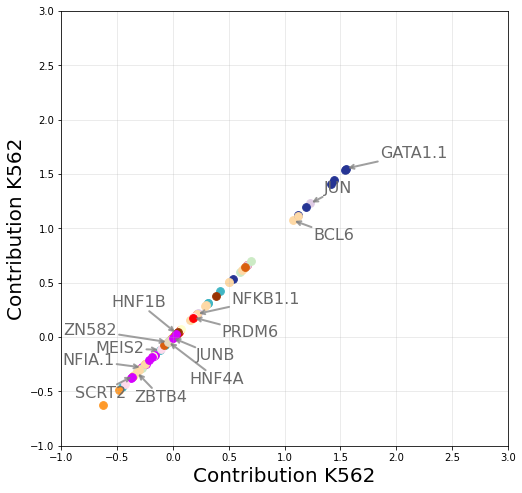

In [ ]:
BG_WHITE = "#fbf9f4"
GREY_LIGHT = "#b4aea9"
GREY50 = "#7F7F7F"
GREY30 = "#4d4d4d"
BLUE_DARK = "#1B2838"
BLUE = "#2a475e"

# motifs_to_display = ['GATA1', 'GATA2', 'TAL1', 'SNAI2', 'GFI1B', 'HNF1B', 'HNF1A', 'HNF4A', 'MAFG', 'MAFK',
#                      'NF2L2', 'MEIS2', 'P53', 'P63', 'IRF2', 'SP1', 'CTCF', 'FOSB', 'JUND', 'TF65', 'FOXB1',
#                      'ELK1', 'STAT2', 'HNF1B.1'
#                      ]
# K562 HepG2 SKNSH
x_cell = 'K562'
y_cell = 'K562'

x_axis = boda2_tf_df[f'contribution_{x_cell}'].tolist()
y_axis = boda2_tf_df[f'contribution_{y_cell}'].tolist()


#---- FIGURE starts here -----

fig, ax = plt.subplots(figsize= (8, 8))
# fig.patch.set_facecolor(BG_WHITE)
# ax.set_facecolor(BG_WHITE)

# ax.scatter(x=x_axis, y=y_axis, marker='o')#, c=text_alphas, cmap='Reds')

for i in range(len(merged_tf_df)):
    ax.scatter(data=merged_tf_df.iloc[i], x=f'contribution_{x_cell}', y=f'contribution_{y_cell}', 
                            color=colors[i], marker='o', s=60)
ax.grid(alpha=0.3)
ax.set_xlim(-1.0, 3)
ax.set_ylim(-1.0, 3)

TEXTS = []
for text in motifs_to_display:
    i = short_names_with_distinction.index(text)
    x = x_axis[i]
    y = y_axis[i]
    TEXTS.append(ax.text(x, y, text.split(' ')[0], color='dimgray', fontsize=16))#, fontname="Poppins"))

adjust_text(
    TEXTS, 
    expand_points=(2, 2),
    arrowprops=dict(
        arrowstyle="->", 
        color=GREY50, 
        lw=2,
        alpha=0.75
    ),
    ax=fig.axes[0]
)

# ax.set_title(
#     f'{x_cell} vs {y_cell} motif contributions',
#     # loc="left",
#     # ha="left",
#     fontsize=24,
#     fontname="Poppins",
#     # color=BLUE_DARK,
#     # weight="bold",
#     pad=15
# )

ax.set_xlabel(f'Contribution {x_cell}', size=20)
ax.set_ylabel(f'Contribution {y_cell}', size=20)

# Hide spines
# ax.spines["right"].set_color("none")
# ax.spines["top"].set_color("none")

fig.show()

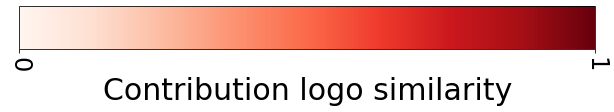

In [ ]:
import pylab as pl

a = np.array([[0,1]])
pl.figure(figsize=(10, 1.0))
img = pl.imshow(a, cmap="Reds")
pl.gca().set_visible(False)
cax = pl.axes([0.1, 0.2, 0.8, 0.6])
pl.colorbar(orientation="horizontal", cax=cax, ticks=[0, 1])
plt.xticks(rotation=270, fontsize=24)
plt.xlabel('Contribution logo similarity', fontsize=30)

# plt.tick_params(
#     axis='x',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     top=False,         # ticks along the top edge are off
#     labelbottom=False)
plt.show()

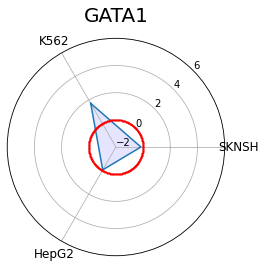

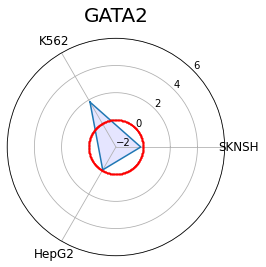

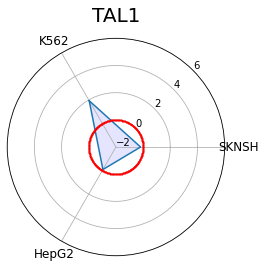

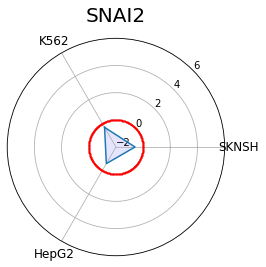

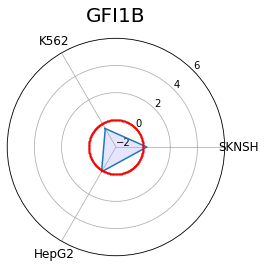

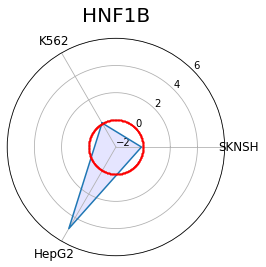

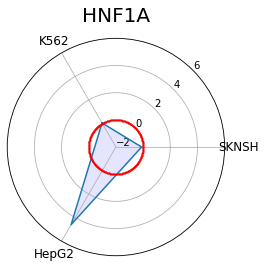

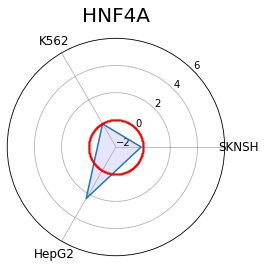

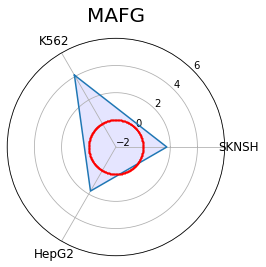

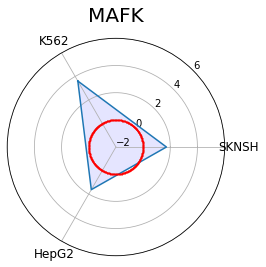

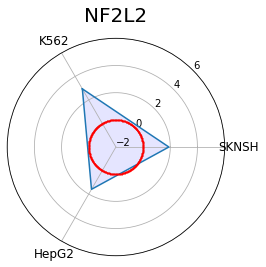

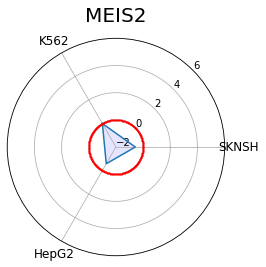

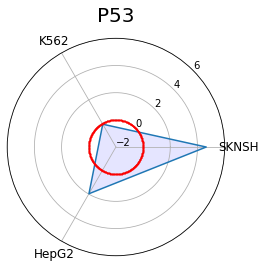

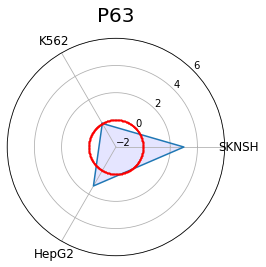

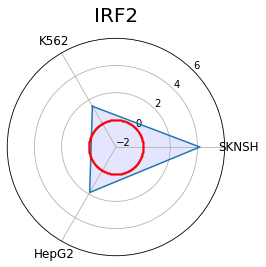

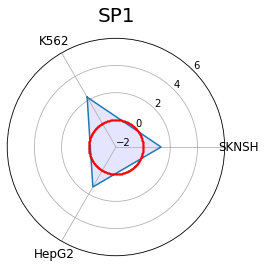

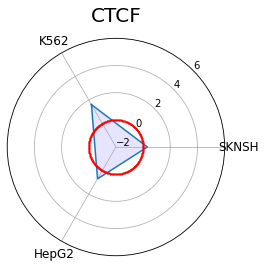

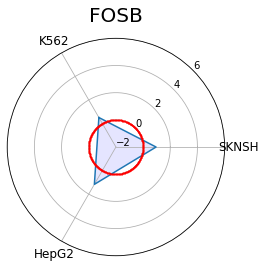

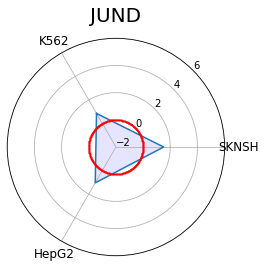

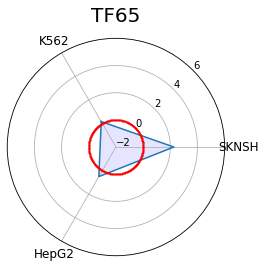

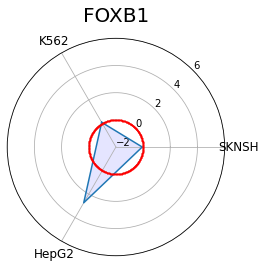

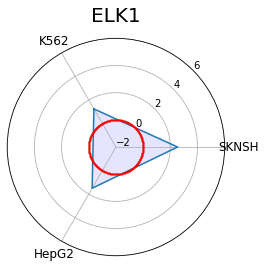

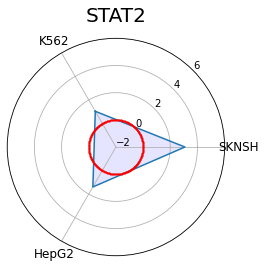

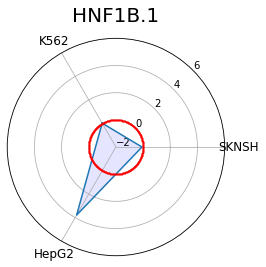

In [ ]:
# motifs_to_display = ['SCRT1', 'HNF4G', 'NR5A2', 'FOXL1', 'HNF1B', 'PITX2']
# motifs_to_display = ['ZN770.1', 'GFI1B', 'RELB', 'ZN770', 'ELF1', 'E2F2', 'BCL6']

cells = [ 'K562', 'HepG2', 'SKNSH',]
contribution_names = ['contribution_K562', 'contribution_HepG2', 'contribution_SKNSH']

for motif_name in motifs_to_display:
    contribs = boda2_tf_df.iloc[short_names_with_distinction.index(motif_name)][contribution_names].tolist()
    contribs.append(contribs[0])

    # plt.figure(figsize =(6, 6))
    # plt.subplot(polar=True)
        
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize =(4, 4))

    theta = np.linspace(2*np.pi/3, 2*np.pi/3 + 2 * np.pi, 4)
    lines, labels = plt.thetagrids(range(120, 120+360, int(360/len(cells))), (cells), fontsize=12)

    ax.plot(theta, contribs)
    ax.fill(theta, contribs, 'b', alpha = 0.1)
    #plt.ylim(-1.5,6)

    r = 0
    rads = np.arange(0, (2 * np.pi), 0.01)
    # plotting the circle
    for i in rads:
        ax.plot(i, r, 'r.', marker='.', markersize=1.0)

    ax.set_rmax(6)
    ax.set_rticks([-2, 0, 2, 4, 6])
    ax.set_rlabel_position(45)

    plt.title(motif_name, fontsize=20)
    plt.show()

### Sequence contributions

In [ ]:
# --- Load library ---
boda2_df = pd.read_csv('/content/drive/MyDrive/data/BODA2_MPRA/BODA2_MPRA_results_pred_contributions_v1.txt', sep=" ", low_memory=False)
data_df = boda2_df[boda2_df['method'].notnull()].reset_index(drop=True)

sequence_column_name = 'sequence'
contribution_columns = ['contrib_K562', 'contrib_HepG2', 'contrib_SKNSH']

In [ ]:
onehot_sequences = torch.stack([utils.dna2tensor(seq) for seq in tqdm(data_df[sequence_column_name].tolist())])

contribution_tensor = []
for contribution_column in tqdm(contribution_columns):
    flat_contributions = torch.stack([str2tensor(contributions).repeat(4,1) \
                                      for contributions in data_df[contribution_column]])
    contribution_tensor.append(flat_contributions * onehot_sequences)

contribution_tensor = torch.stack(contribution_tensor)

  0%|          | 0/117900 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
top_n = 15
cell_type = 'hepg2'
lfcSE_threshold = 0.5
methods = ['fsp', 'sa', 'al']

quality_filter = (data_df['K562_lfcSE'] <= lfcSE_threshold) & (data_df['HepG2_lfcSE'] <= lfcSE_threshold) & (data_df['SKNSH_lfcSE'] <= lfcSE_threshold)
target_cell_filter = data_df['target_cell'] == cell_type
method_filter = data_df['method'].isin(methods)
better_df = data_df[quality_filter & target_cell_filter & method_filter]

to_look_df = better_df.sort_values('OverMax', ascending=False)[:top_n]
to_look_df[['ID', 'K562_signal', 'HepG2_signal', 'SKNSH_signal', 'OverMax']]

# for j in range(top_n):
#     print(to_look_df.iloc[j][['ID', 'K562_signal', 'HepG2_signal', 'SKNSH_signal', 'OverMax', 'K562_pred_aggreg', 'HepG2_pred_aggreg', 'SKNSH_pred_aggreg']])
#     original_idx = to_look_df.iloc[j].name
#     y_max = contribution_tensor[:, original_idx, ...].max()
#     for i in range(3):
#         matrix_to_dms(contribution_tensor[i, original_idx, ...], y_max=y_max)
#         plt.show()
#     print('')

,ID,K562_signal,HepG2_signal,SKNSH_signal,OverMax
51773,20211206_25528__41332638__78::al__hepg2__1,-0.628944,6.450125,-1.788051,7.079069
53525,20211206_24503__33072627__1397::al__hepg2__0,-0.814104,6.229169,-0.920081,7.043273
55033,20211206_24503__33072627__2978::al__hepg2__0,-1.176638,5.750728,-1.318778,6.927366
8298,20211207_100944__255626__61::sa__hepg2__0,-0.510267,6.411923,-0.612734,6.922190
54292,20211206_24503__33072627__2199::al__hepg2__0,-0.534135,6.322139,-0.935648,6.856274
55976,20211206_24503__33072627__3971::al__hepg2__0,-0.680279,6.147100,-0.681976,6.827379
52461,20211206_24503__33072627__283::al__hepg2__0,-1.025927,5.731628,-1.885186,6.757556
8325,20211207_100944__255626__132::sa__hepg2__0,-0.686803,6.034644,-1.087801,6.721447
72438,20211212_55149__346635__38::fsp__hepg2__0,-0.618553,6.099193,-0.870771,6.717746
53272,20211206_24503__33072627__1131::al__hepg2__0,-0.678557,6.037972,-1.329967,6.716528


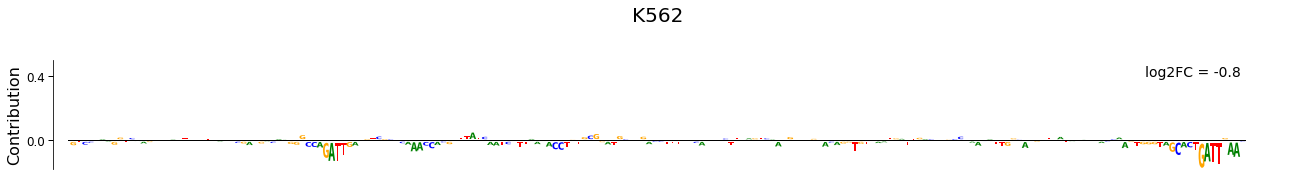

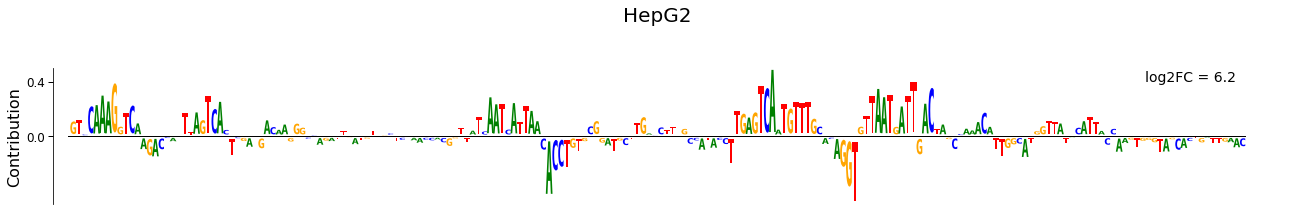

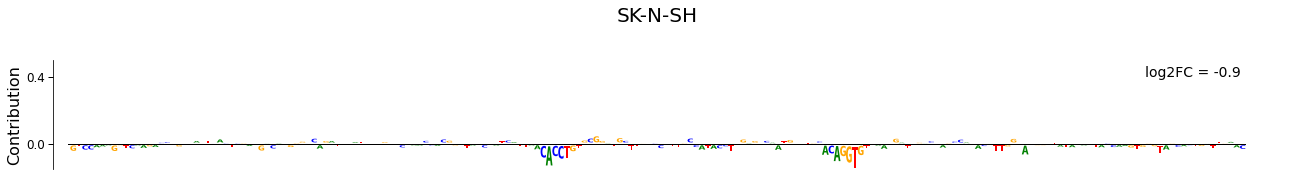

In [ ]:
j = 1
original_idx = to_look_df.iloc[j].name

titles = ['K562', 'HepG2', 'SK-N-SH']
l2fcs = np.around(to_look_df.iloc[j][['K562_signal', 'HepG2_signal', 'SKNSH_signal']].tolist(), 1)
l2fcs = [f'log2FC = {l2fc}' for l2fc in l2fcs]

heightscales = [0.8, 1.0, 0.8]
#heightscales = 3*[0.8]

y_max = contribution_tensor[:, original_idx, ...].max()
y_min = contribution_tensor[:, original_idx, ...].min()
for i in [0, 1, 2]:
    fig, ax = matrix_to_dms(contribution_tensor[i, original_idx, ...], y_max=y_max,
                            fontaspect=0.5, widthscale=0.3, axisfontscale=0.6, heightscale=heightscales[i])
    ax.spines['left'].set_position(('outward', 15))
    ax.spines['bottom'].set_visible(False)
    plt.xticks([])
    plt.yticks([0, 0.4],  fontsize=12)
    plt.xlabel('')
    plt.ylabel('Contribution', fontsize=16)
    plt.title(titles[i], fontsize=20, y=1.3)
    plt.text(183, 0.4, f'{l2fcs[i]}', fontsize=14)
    plt.savefig(f'{titles[i]}_contribution.png', format='png', dpi=300, transparent=True, bbox_inches='tight')
    plt.show()

### Some motif logos from penalization

In [ ]:
icms = [np.array([[0.01327891, 0.01145237, 0.03811173, 0.06272471, 0.0419636 ,
         0.0434601 , 1.36736446, 0.02279541, 0.01377473, 0.14266948,
         0.00318951, 0.01410684],
        [0.01067358, 0.01074924, 0.36684214, 0.99656836, 0.03781219,
         0.03627378, 0.04281415, 0.01723699, 1.6193179 , 0.03339509,
         0.00463897, 0.01340012],
        [0.01005832, 0.00948343, 0.04886119, 0.02197654, 0.01983157,
         0.02129571, 0.03130659, 0.01596566, 0.01629484, 0.02564698,
         0.00439806, 0.00823068],
        [0.01954585, 0.01825187, 0.11161428, 0.09355954, 1.460952  ,
         1.45253068, 0.04138199, 1.68892979, 0.04075143, 0.89751398,
         0.00482094, 0.01850064]]),
 np.array([[1.12989653e-02, 3.02086313e-02, 1.86601455e-02, 1.59214955e-03,
         1.83694992e+00, 1.59214955e-03, 1.87044114e+00, 4.97683697e-02,
         3.27163835e-02, 5.93670747e-02, 1.90056557e-02],
        [8.30423314e-03, 1.83547931e-02, 1.32774112e-02, 2.18920563e-03,
         7.54936779e-04, 1.96570764e+00, 3.82738109e-04, 5.80775235e-02,
         1.00217937e-01, 8.07641943e-02, 1.79963029e-02],
        [1.12218063e-02, 3.11844921e-02, 1.65070518e-02, 1.96570764e+00,
         3.00087370e-02, 1.19411216e-03, 2.27729175e-02, 6.56596265e-01,
         1.33968714e-01, 4.77887924e-02, 4.67513898e-02],
        [1.69267470e-02, 6.23546333e-02, 1.72821655e+00, 1.19411216e-03,
         1.13240517e-03, 2.18920563e-03, 1.33958338e-03, 9.26124444e-02,
         2.57416170e-02, 3.74080678e-01, 2.98217893e-02]]),
 np.array([[0.03435007, 0.08608399, 0.69727103, 0.04304565, 0.02120785,
         0.02513032, 0.11967654, 0.02205465, 0.04549205],
        [0.03794484, 0.08982677, 0.00213887, 0.01986722, 1.65067767,
         0.01077014, 1.39517655, 0.01837887, 0.61667004],
        [0.09426298, 0.70364304, 0.00427774, 1.51653145, 0.02827713,
         1.6837316 , 0.00629877, 1.73496561, 0.08087476],
        [0.02716052, 0.02807087, 0.33366344, 0.02648963, 0.01413857,
         0.02154028, 0.00629877, 0.00735155, 0.0741352 ]]),
 np.array([[2.14506946e-02, 3.85984577e-02, 1.06147872e-01, 1.99049619e+00,
         4.01633614e-04, 4.01633614e-04, 3.52271599e-01, 2.27775975e-02,
         3.74107052e-03, 2.93998051e-03, 1.55483144e-02, 7.91329738e-03,
         4.30750055e-03, 2.69635795e-02, 3.90903365e-02, 4.02588518e-02,
         1.56695040e+00, 2.50854683e-02],
        [3.92268757e-02, 1.50664511e-01, 3.32751951e-04, 4.01633614e-04,
         4.01633614e-04, 1.99049619e+00, 1.09977475e-02, 4.60390894e-02,
         4.71514593e-03, 2.78212920e-03, 9.88484741e-03, 9.42893374e-03,
         3.63893062e-03, 1.47827896e-02, 3.50172479e-02, 1.74926525e+00,
         3.36255450e-04, 1.38827032e-01],
        [1.86226658e-02, 2.98345566e-02, 3.32751951e-04, 4.01633614e-04,
         4.01633614e-04, 4.01633614e-04, 9.62302906e-03, 7.65589963e-02,
         4.83156929e-03, 3.75143486e-03, 8.66125887e-03, 1.30466587e-02,
         4.67043851e-03, 1.17375921e-02, 5.33178613e-02, 8.70461661e-03,
         3.36255450e-04, 5.52347733e-01],
        [1.61024497e-02, 7.05587265e-01, 1.54330355e+00, 4.01633614e-04,
         1.99049619e+00, 4.01633614e-04, 4.79261215e-01, 2.60266023e-02,
         5.95699507e-03, 2.75746494e-03, 9.24683338e-03, 7.38015896e-03,
         3.17093167e-03, 1.74133827e-02, 1.28415433e-02, 3.62692359e-04,
         9.98678686e-02, 5.64033510e-02]]),
 np.array([[0.14866188, 0.01831974, 0.0074415 , 0.02465856, 0.02231203,
         0.01115647, 0.00545547, 0.06704391, 0.0205063 , 0.03207336],
        [0.00775015, 0.00366395, 0.00372075, 0.01056795, 0.35539879,
         0.01115647, 0.00545547, 0.02320751, 0.05126576, 0.36082534],
        [0.07256954, 1.81365419, 1.84921393, 1.72609931, 0.00478115,
         1.84825477, 0.40006771, 1.14490376, 1.13297327, 0.0400917 ],
        [0.126116  , 0.01099184, 0.01488301, 0.01409061, 0.42074117,
         0.00371882, 0.5055401 , 0.0644653 , 0.08715179, 0.14433014]]),
 np.array([[5.87785437e-03, 1.46296419e-03, 1.96280985e+00, 2.98014774e-04,
         1.95161310e+00, 1.75906368e-03, 3.66077660e-02, 3.02691456e-04,
         1.77658813e-03, 7.01237554e-03, 5.31318142e-03, 1.89166424e+00],
        [2.93892718e-03, 1.31666777e-03, 8.89255792e-04, 1.98254328e+00,
         1.32133588e-03, 2.46268916e-03, 8.53615523e-01, 9.53478085e-03,
         2.07268616e-03, 3.81107367e-03, 1.93658283e+00, 3.76867253e-03],
        [2.93892718e-04, 1.97500165e+00, 4.66859291e-03, 8.94044321e-04,
         5.06512089e-03, 1.48629154e+00, 2.03726662e-01, 1.36211155e-03,
         1.96342599e+00, 6.09771786e-04, 2.01039297e-03, 6.90923297e-03],
        [1.94292476e+00, 7.31482094e-04, 2.22313948e-04, 1.19205909e-03,
         1.10111324e-03, 1.13049159e-01, 1.05055399e-03, 1.93359302e+00,
         1.48049011e-03, 1.92947038e+00, 2.58479096e-03, 7.11860367e-03]]),
 np.array([[0.59416085, 0.83816996, 0.01863843, 1.61821792, 0.0141671 ,
         0.01977274, 0.0231174 , 0.01890992, 0.04071428, 0.01260411],
        [0.00848801, 0.15566014, 1.30469005, 0.0231174 , 0.1841723 ,
         1.38409148, 0.0231174 , 0.01890992, 0.11196428, 0.12604105],
        [0.16127223, 0.04789543, 0.07455372, 0.0231174 , 0.991697  ,
         0.07909094, 0.0231174 , 1.32369407, 0.05089285, 0.06302053],
        [0.0679041 , 0.01197386, 0.03727686, 0.0231174 , 0.0141671 ,
         0.01977274, 1.61821792, 0.09454958, 0.71249993, 0.88228738]]),
 np.array([[0.00734838, 0.06797252, 0.04862994, 0.0261038 , 0.02263211,
         0.51043591, 0.72174368, 0.00819258, 1.63069696, 1.5270054 ,
         0.00537237, 0.01199575],
        [0.00471093, 0.0804881 , 0.02879405, 1.70726643, 1.27211312,
         0.09418758, 0.0174407 , 0.00942146, 0.01578821, 0.02393201,
         0.00385776, 0.01258469],
        [0.0055569 , 0.04488344, 0.04639041, 0.01051944, 0.00911571,
         0.02206772, 0.2112263 , 1.81957128, 0.01879549, 0.03643381,
         0.00370779, 0.00710859],
        [0.00736497, 0.78157613, 1.32164667, 0.01636358, 0.11630389,
         0.09578669, 0.022393  , 0.01351775, 0.03308007, 0.02643237,
         0.00400022, 0.01499211]]),
 np.array([[0.01823157, 0.01278575, 0.06412345, 0.1280602 , 0.01948945,
         1.05811752, 0.01538826, 0.66167305, 0.01459264, 0.12048449,
         0.00995641, 0.61250915, 0.03130339, 0.02063455, 0.01741459,
         0.01343872],
        [0.03541891, 0.008149  , 0.09727145, 0.48973077, 1.67216782,
         0.12368862, 1.72348468, 0.03693203, 1.58028574, 1.0971083 ,
         1.67179585, 0.14111316, 0.81495401, 0.02612503, 0.04456796,
         0.02177274],
        [0.01769075, 0.01240933, 0.3774616 , 0.04559657, 0.01976014,
         0.03425595, 0.02453803, 0.1496937 , 0.04773415, 0.03005912,
         0.01395252, 0.02773491, 0.07022539, 0.00976942, 0.01874049,
         0.01299503],
        [0.01567711, 0.00746155, 0.03413348, 0.03889846, 0.01982781,
         0.02000277, 0.00991226, 0.03389747, 0.01660318, 0.02132908,
         0.03704867, 0.05046259, 0.09339701, 0.01943787, 0.02764899,
         0.01030317]]),
 np.array([[5.71692549e-02, 1.14259865e-01, 5.29341616e-02, 8.19613399e-03,
         4.70535558e-02, 4.21900537e-02, 2.21271356e-03, 2.35882599e-02,
         8.88572959e-01, 4.39448320e-02, 9.32337954e-02, 1.55601191e-01],
        [1.18003206e-01, 6.69799210e-02, 1.04997255e+00, 9.87949382e-01,
         1.63850938e+00, 8.43801074e-03, 1.73366108e+00, 3.52026698e-01,
         7.31499117e-02, 2.71184764e-02, 2.72502095e-02, 4.04183582e-02],
        [2.89510970e-02, 2.72985392e-02, 1.14579008e-01, 2.36426942e-01,
         7.31944201e-03, 1.65279535e+00, 2.98716331e-02, 1.20861751e-01,
         5.44371436e-02, 1.29562938e-02, 2.74287043e-02, 2.84636325e-02],
        [3.71233687e-01, 4.40998051e-01, 1.13908955e-02, 6.30471845e-04,
         1.46388840e-02, 1.47665188e-02, 1.77017085e-02, 6.17787760e-02,
         5.55712508e-02, 2.97826494e-02, 5.00380485e-02, 7.34361719e-02]]),
 np.array([[1.42622492e+00, 6.58723560e-02, 3.74045803e-03, 9.46595822e-03,
         1.89007732e-04, 1.83699382e-02, 5.04570058e-03, 1.61356385e+00],
        [1.01844110e-02, 1.46383013e-02, 1.49618321e-03, 2.68711072e-02,
         1.70106958e-03, 5.68034969e-02, 5.10176392e-02, 1.10612774e-02],
        [9.03017775e-02, 1.50731450e+00, 1.96430153e+00, 3.75584794e-02,
         1.98514820e+00, 4.23420562e-02, 1.17766652e+00, 4.71640579e-02],
        [1.53445126e-02, 1.49253268e-02, 1.87022902e-04, 1.60356386e+00,
         1.89007732e-04, 1.36836497e+00, 1.05174825e-01, 1.49019988e-02]]),
 np.array([[9.23579969e-02, 9.21735434e-01, 8.58293138e-02, 4.35543639e-03,
         3.08437090e-03, 2.00157731e-03, 4.71884674e-02, 2.15785244e-02,
         1.83655084e+00, 2.87299853e-01, 8.13312816e-02, 6.10745190e-02,
         3.04267215e-03],
        [1.86062499e-02, 1.49044985e-02, 4.85689529e-02, 1.68773160e-02,
         9.26853454e-02, 1.80141958e-03, 1.46607718e-01, 5.63496063e-02,
         5.41645218e-03, 5.71794785e-02, 3.58807180e-02, 2.11977224e-02,
         3.13509544e-03],
        [4.64136167e-02, 1.18111120e-01, 4.75202501e-01, 1.78445858e+00,
         7.86514579e-03, 1.96815097e+00, 9.41866587e-03, 1.00560014e+00,
         1.86774213e-02, 2.98899369e-02, 2.43340415e-02, 2.12625803e-02,
         2.37746765e-03],
        [4.33125751e-02, 6.13052959e-02, 6.31154751e-02, 1.72402690e-02,
         1.51643095e+00, 8.00630923e-04, 9.35492339e-01, 1.00324798e-01,
         4.66935533e-03, 9.79384833e-02, 3.12818984e-02, 4.52275730e-02,
         3.40628485e-03]]),
 np.array([[4.04014764e-03, 6.58972689e-03, 1.41987111e-02, 1.13869745e-01,
         2.48763920e-02, 1.76708535e+00, 2.12156534e-02, 1.24987096e+00,
         2.21706136e-02, 2.28153403e-02, 4.00682967e-02, 7.06744674e-03,
         1.20804616e-03],
        [2.79463754e-03, 4.65905400e-03, 8.66202385e-03, 6.22502170e-01,
         1.75490441e+00, 9.06231536e-03, 6.35507441e-02, 8.60257772e-02,
         2.83015933e-02, 2.37734648e-02, 6.49275396e-02, 1.28519548e-02,
         1.16166455e-03],
        [3.14578603e-03, 4.82078576e-03, 1.08755684e-02, 7.12677005e-02,
         7.76564617e-03, 1.39572886e-02, 1.16262743e+00, 4.63254926e-02,
         1.78975065e-02, 1.55551517e+00, 9.04983172e-02, 1.26280048e-02,
         1.10005844e-03],
        [3.27819423e-03, 6.95783511e-03, 1.77629889e-02, 2.60125582e-02,
         1.15168481e-02, 1.81907790e-02, 6.77361451e-02, 1.09570747e-02,
         1.62458577e+00, 3.49116624e-02, 4.12356583e-01, 1.49109064e-02,
         1.36967367e-03]]),
 np.array([[0.10492805, 0.0491505 , 0.01061503, 0.01038857, 0.01061503,
         0.01061503, 0.00976074, 1.59439183, 0.46804641, 0.02548231],
        [0.06495546, 1.6416266 , 1.81516992, 0.01038857, 0.01061503,
         1.81516992, 0.02928223, 0.00960477, 0.05432682, 0.11212218],
        [0.66454429, 0.0098301 , 0.01061503, 1.76605659, 0.01061503,
         0.01061503, 1.63004391, 0.01920954, 0.19641233, 0.67782952],
        [0.03497602, 0.0098301 , 0.01061503, 0.02077714, 1.81516992,
         0.01061503, 0.02928223, 0.04802385, 0.00835797, 0.07135048]]),
 np.array([[1.74149419, 0.00988812, 0.01282083, 0.07298826, 1.61463571,
         0.01017053, 0.01527626, 1.04176123, 0.12613406, 0.07618476,
         0.06926698, 0.02395588, 0.01020614, 0.11109437],
        [0.01527626, 0.91959511, 0.01282083, 1.04268943, 0.01441639,
         0.01017053, 1.74149419, 0.04167045, 0.51084294, 0.06274039,
         0.06926698, 0.15970589, 0.14288597, 0.07776606],
        [0.01527626, 0.19776239, 0.10256661, 0.01042689, 0.04324917,
         0.94585921, 0.01527626, 0.11459374, 0.0063067 , 0.04481457,
         0.0115445 , 0.03992647, 0.04082456, 0.02221887],
        [0.01527626, 0.01977624, 1.37182845, 0.09384205, 0.01441639,
         0.21358111, 0.01527626, 0.02083522, 0.10090725, 0.34507216,
         1.2006276 , 0.71069119, 1.0002018 , 0.44437747]]),
 np.array([[0.01775928, 0.06976494, 0.13606744, 0.02754344, 1.40471548,
         0.04943015, 0.02644436, 0.02553629, 0.15402369, 1.03633885],
        [0.74588985, 0.06976494, 1.0658616 , 0.02754344, 0.02754344,
         0.07414523, 1.29577349, 0.05107259, 0.84713028, 0.04409953],
        [0.03551856, 1.09298413, 0.02267791, 0.05508688, 0.02754344,
         0.02471508, 0.07933307, 0.05107259, 0.03850592, 0.02204976],
        [0.17759282, 0.02325498, 0.02267791, 1.40471548, 0.05508688,
         1.18632366, 0.02644436, 1.30235097, 0.01925296, 0.11024881]]),
 np.array([[0.44939356, 0.02687125, 0.02687125, 1.55853248, 0.01315263,
         0.02687125, 0.02687125, 1.55853248, 0.02496631],
        [0.2746294 , 0.02687125, 0.02687125, 0.02687125, 0.38142622,
         0.02687125, 1.55853248, 0.02687125, 0.01248315],
        [0.01248315, 0.02687125, 1.55853248, 0.02687125, 0.38142622,
         0.02687125, 0.02687125, 0.02687125, 0.2746294 ],
        [0.02496631, 1.55853248, 0.02687125, 0.02687125, 0.01315263,
         1.55853248, 0.02687125, 0.02687125, 0.44939356]]),
 np.array([[0.07388728, 0.01264303, 0.05057211, 0.07593676, 0.02073659,
         0.09064631, 0.05562166, 0.02052362, 1.53322946, 0.06155689,
         0.05394384],
        [0.08866474, 0.73329556, 0.01264303, 1.29092495, 1.45156103,
         0.01812926, 0.86213576, 0.02052362, 0.02159478, 0.07576232,
         0.01798128],
        [0.19703275, 0.05057211, 0.16435935, 0.01898419, 0.06220976,
         0.03625853, 0.02781083, 1.45717718, 0.04318956, 0.19887609,
         1.222727  ],
        [0.01477746, 0.16435935, 0.73329556, 0.03796838, 0.02073659,
         1.23278988, 0.11124332, 0.06157087, 0.02159478, 0.02367573,
         0.07192512]])]

labels = ['GATA4', 'MEIS3', 'ZBT14', 'GATA1::TAL1', 'KLF4', 'TGIF1', 'MSC', \
          'Stat5a', 'KLF9', 'E2F8', 'TBX15', 'EOMES', 'TWIST1', 'STREME-6', 'STREME-11', 'STREME-13', 'STREME-14', 'STREME-15']

GATA4


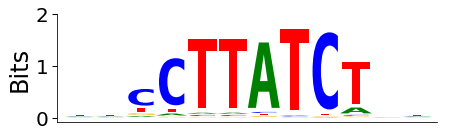

MEIS3


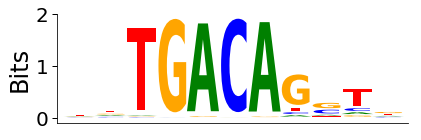

ZBT14


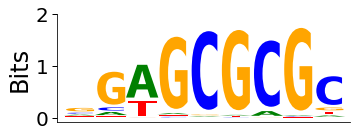

GATA1::TAL1


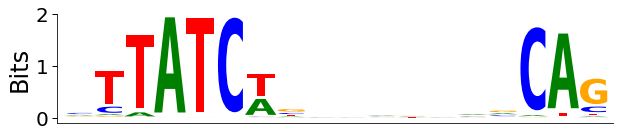

KLF4


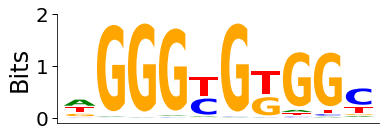

TGIF1


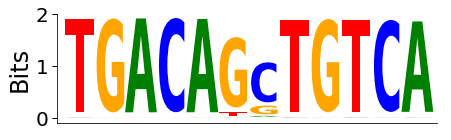

MSC


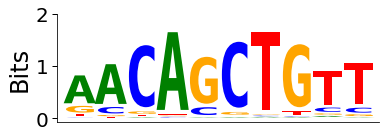

Stat5a


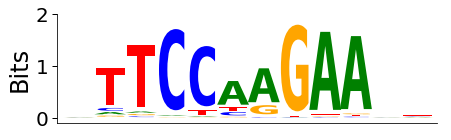

KLF9


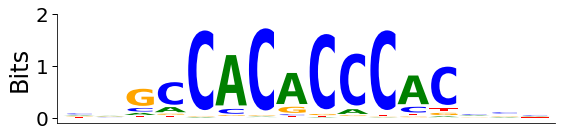

E2F8


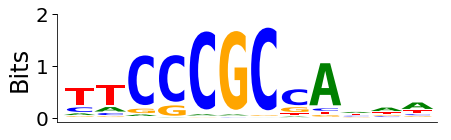

TBX15


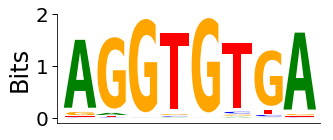

EOMES


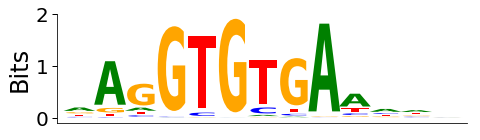

TWIST1


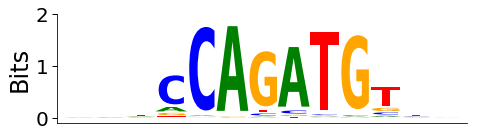

STREME-6


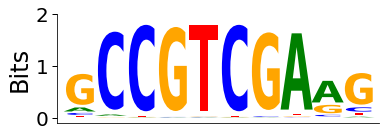

STREME-11


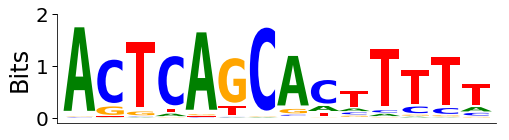

STREME-13


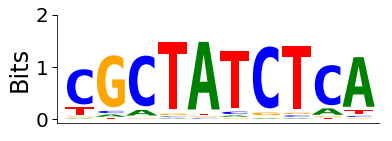

STREME-14


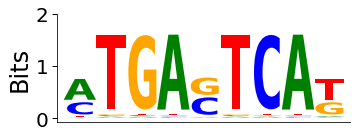

STREME-15


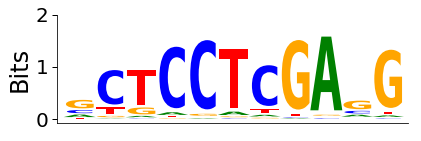

In [ ]:
for icm, label in zip(icms, labels):
    print(label)
    fig, ax = matrix_to_dms(torch.Tensor(icm), widthscale=1.5)
    #ax.spines['left'].set_position(('outward', 15))
    #ax.spines['bottom'].set_visible(False)
    plt.xticks([])
    plt.yticks([0, 1, 2],  fontsize=20)
    plt.xlabel('')
    plt.ylabel('Bits', fontsize=24)
    #plt.title(titles[i], fontsize=20, y=1.3)
    #plt.text(183, 0.4, f'{l2fcs[i]}', fontsize=14)
    plt.show()